In [31]:
import pandas as pd

import tensorflow as tf
import json
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
from cell_division.nets.custom_layers import (
    w_cel_loss, 
    focal_loss,
    ExtendedLSEPooling,
    extended_w_cel_loss,
    LSEPooling
)

from cell_division.nets.grad_cam import GradCAM, overlay_heatmap, CAM

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)

increase_gpu_memory()
set_gpu_allocator()

ValueError: Cannot set memory growth on device when virtual devices configured

Merge the datasets

In [4]:
img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/train.csv'
label_test_dir = v.data_path + 'CellDivision/test.csv'
label_val_dir = v.data_path + 'CellDivision/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train = pd.read_csv(label_train_dir)
val = pd.read_csv(label_val_dir)
test = pd.read_csv(label_test_dir)

print(f'Train: {len(train)}\nVal: {len(val)}\nTest: {len(test)}')

Train: 767
Val: 165
Test: 165


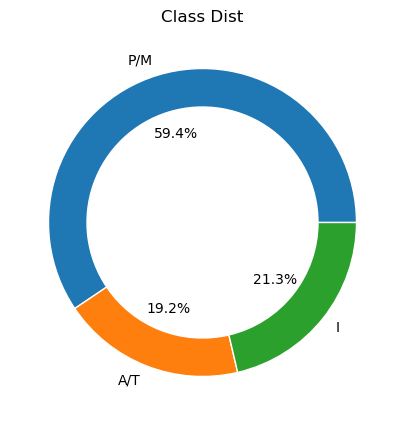

In [4]:
data = pd.concat([train, val, test], ignore_index=True)
data.columns = ['img', 'label']

plt.figure(figsize=(5, 5))
plt.pie(
    np.bincount(data.label.astype(int)), 
    labels=['P/M', 'A/T', 'I'],
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    autopct='%.1f%%',
    wedgeprops=dict(width=.25, edgecolor='w')
)

plt.title('Class Dist')	
plt.show()

Random Under Sampling

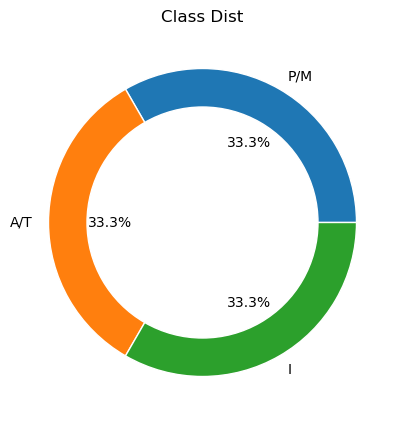

In [5]:
from imblearn.under_sampling import RandomUnderSampler

X = data.img.values.reshape(-1, 1)
y = data.label.values

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

data_resampled = pd.DataFrame({'img': X_resampled.flatten(), 'label': y_resampled})

plt.figure(figsize=(5, 5))
plt.pie(
    np.bincount(data_resampled.label.astype(int)), 
    labels=['P/M', 'A/T', 'I'],
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    autopct='%.1f%%',
    wedgeprops=dict(width=.25, edgecolor='w')
)

plt.title('Class Dist')
plt.show()

Split the dataset

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_resampled, test_size=0.2, random_state=42, stratify=data_resampled.label)
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train.label)

print(f'Train: {len(train)}\nVal: {len(val)}\nTest: {len(test)}')

Train: 404
Val: 102
Test: 127


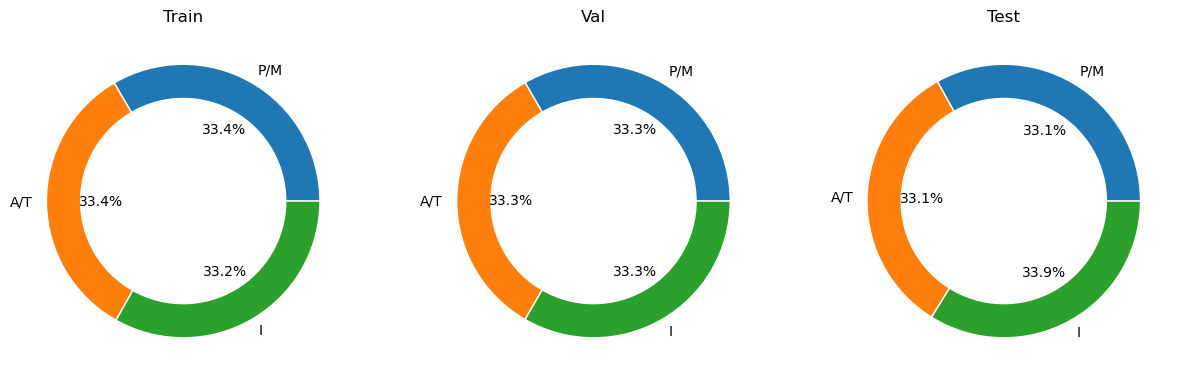

In [7]:
plt.figure(figsize=(15, 5))

for i, dataset in enumerate([train, val, test]):
    plt.subplot(1, 3, i+1)
    plt.pie(
        np.bincount(dataset.label.astype(int)), 
        labels=['P/M', 'A/T', 'I'],
        colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
        autopct='%.1f%%',
        wedgeprops=dict(width=.25, edgecolor='w')
    )

    plt.title(['Train', 'Val', 'Test'][i])
    
plt.show()

Create the generators

In [8]:
# Save the datasets as csv
train.to_csv(v.data_path + 'CellDivision/undersampled/train.csv', index=False, header=False)
val.to_csv(v.data_path + 'CellDivision/undersampled/val.csv', index=False, header=False)
test.to_csv(v.data_path + 'CellDivision/undersampled/test.csv', index=False, header=False)

In [2]:
img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

In [5]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 4.4302 - auc: 0.5924

2024-08-06 18:04:56.020580: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/cellular_division_models/vgg16.ckpt/assets
13/13 [==============================] - 15s 1s/step - loss: 4.4302 - auc: 0.5924 - val_loss: 1.4306 - val_auc: 0.6678 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 10s 804ms/step - loss: 2.2448 - auc: 0.7911 - val_loss: 1.3468 - val_auc: 0.8140 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 10s 830ms/step - loss: 1.9012 - auc: 0.8432 - val_loss: 1.3125 - val_auc: 0.8375 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.0962 - auc: 0.9077
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
13/13 [==============================] - 10s 800ms/step - loss: 1.0962 - auc: 0.9077 - val_loss: 1.2984 - val_auc: 0.7704 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 10s 814ms/step - loss: 1.4840 - auc: 0.8762 - val_loss: 1.2570 - val_auc: 0.8267 - lr: 1.0000e-04
Epoch 6/100
13/13 [==============

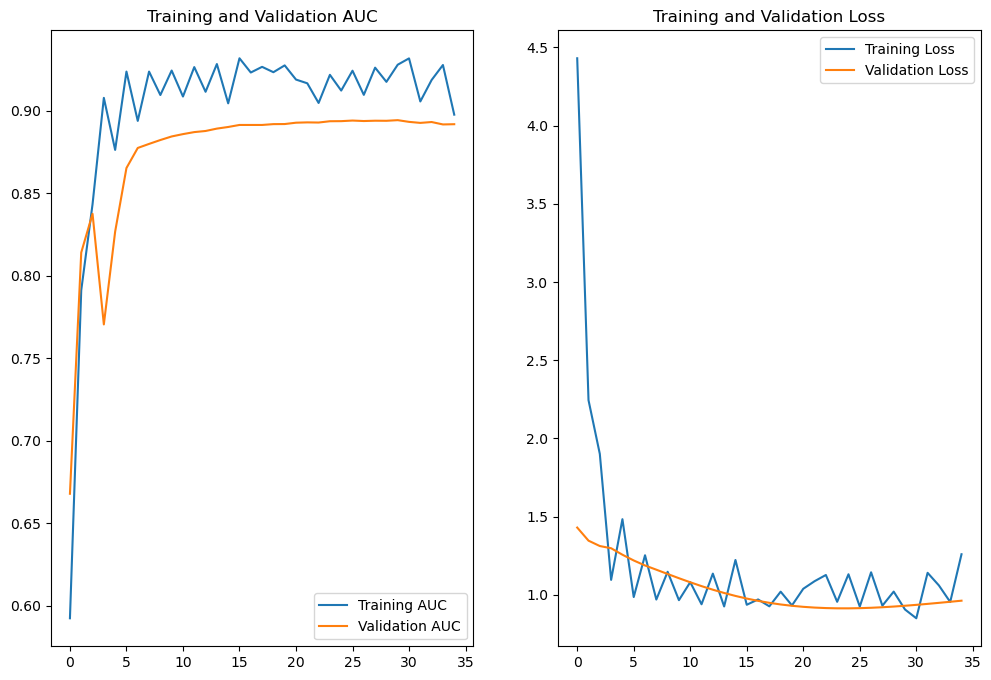

In [11]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)
model.fit(
    train_generator,
    val_generator,
    epochs=100,
    verbose=2,
    save=True,
    batch_size=BATCH_SIZE
)

model.model.save('../models/cellular_division_models/vgg16_undersampling.h5')

In [19]:
model = CNN()
model.load('../models/cellular_division_models/vgg16_undersampling.h5')

In [20]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 3s 779ms/step - loss: 0.8486 - auc: 0.9020


In [21]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.73      0.79      0.76        42
Anaphase/Telophase       0.77      0.71      0.74        42
        Interphase       0.72      0.72      0.72        43

          accuracy                           0.74       127
         macro avg       0.74      0.74      0.74       127
      weighted avg       0.74      0.74      0.74       127



<Figure size 1200x1200 with 0 Axes>

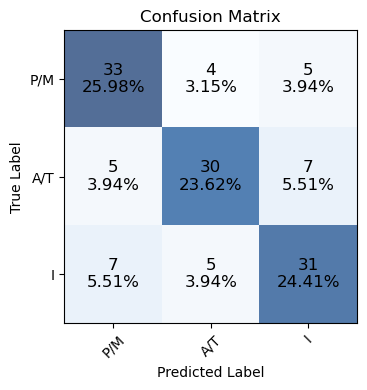

In [22]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [ ]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

In [ ]:
img_idx = 85 # 0  # 98
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

In [ ]:
cam = GradCAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.6)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.6)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.6)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

In [ ]:
cam = CAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0, normalize=True)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1, normalize=True)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2, normalize=True)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.6)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.6)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.6)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

Hyperparameter tuning (Under Sampling)

In [10]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)): 
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

In [6]:
param_grid = {
    'top': ['CAM', 'STD'],
    'fine_tune': [True, False],
    'pooling': [ExtendedLSEPooling, GlobalAveragePooling2D],
    'loss': [w_cel_loss(), focal_loss(), extended_w_cel_loss()],
    'lr': [1e-2, 1e-3]
}

In [7]:
bar = LoadingBar(len(param_grid['top']) * len(param_grid['fine_tune']) * len(param_grid['pooling']) * len(param_grid['loss']) * len(param_grid['lr']))

results = {}

for top in param_grid['top']:
    for fine_tune in param_grid['fine_tune']:
        for pooling in param_grid['pooling']:
            for loss in param_grid['loss']:
                for lr in param_grid['lr']:
                    print(f'{top} - {fine_tune} - {pooling.__name__} - {loss.__name__} - {lr}')
                    
                    try:
                        model = CNN(
                            base=tf.keras.applications.VGG16,
                            input_shape=INPUT_SHAPE,
                            n_classes=3
                        )
                        model.build_top(activation='softmax', b_type=top, pooling=pooling)
                        model.compile(
                            lr=lr,
                            loss=loss
                        )
                        model.fit(
                            train_generator,
                            val_generator,
                            epochs=100,
                            verbose=1,
                            save=False,
                            batch_size=BATCH_SIZE
                        )
                        results[
                            str((top, fine_tune, pooling.__name__, loss.__name__, lr))
                        ] = model.model.history.history
                    except Exception as e:
                        print(e)
                        results[str((top, fine_tune, pooling.__name__, loss.__name__, lr))] = None
                        
                    clear_session()
                    bar.update()
                    
with open('../cell_division/results/results_under.json', 'w') as f:
    json.dump(results, f)
    
bar.end()

CAM - True - ExtendedLSEPooling - weighted_cross_entropy_with_logits - 0.01
Epoch 1/100
24/24 [==============================] - 30s 1s/step - loss: 1.0192 - auc: 0.6948 - val_loss: 1.0420 - val_auc: 0.6591 - lr: 0.0100
Epoch 2/100
24/24 [==============================] - 19s 787ms/step - loss: 1.0094 - auc: 0.7008 - val_loss: 1.0420 - val_auc: 0.6591 - lr: 0.0100
Epoch 3/100
24/24 [==============================] - 19s 779ms/step - loss: 1.0094 - auc: 0.7008 - val_loss: 1.0420 - val_auc: 0.6591 - lr: 0.0100
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 1.0094 - auc: 0.7008
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
24/24 [==============================] - 19s 779ms/step - loss: 1.0094 - auc: 0.7008 - val_loss: 1.0420 - val_auc: 0.6591 - lr: 0.0100
Epoch 5/100
24/24 [==============================] - 18s 772ms/step - loss: 1.0094 - auc: 0.7008 - val_loss: 1.0420 - val_auc: 0.6591 - lr: 1.0000e-03
Epoch 6/100
24/24 [===============

FileNotFoundError: [Errno 2] No such file or directory: '/run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/../cell_division/results/results_under.json'

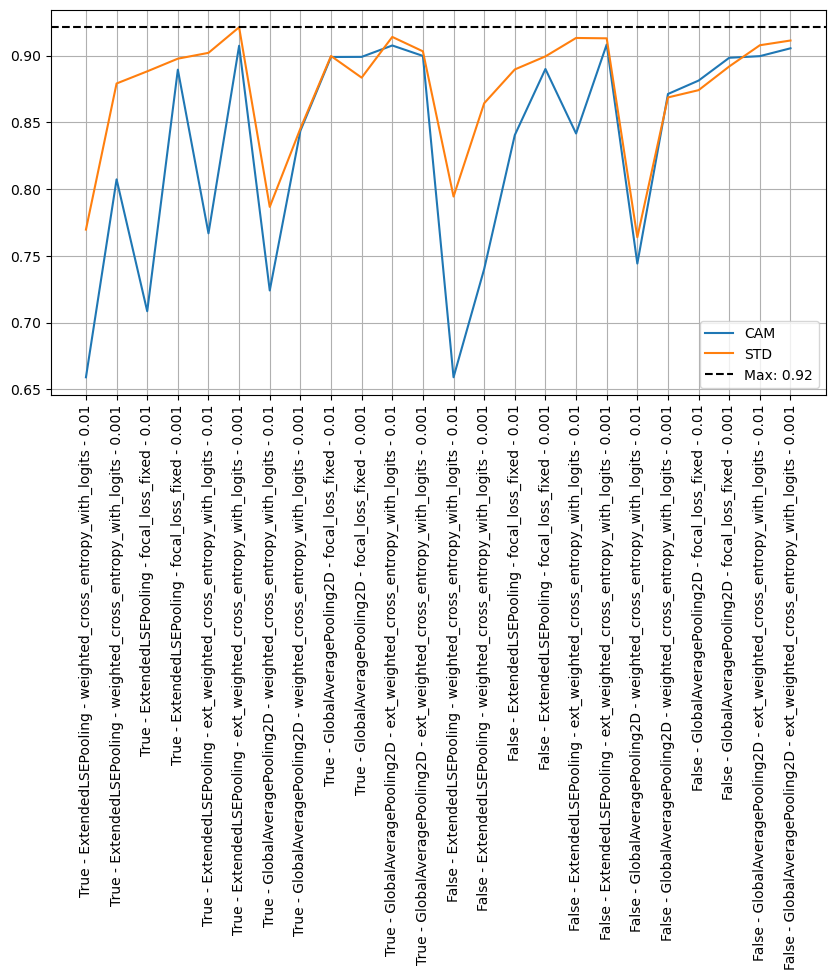

In [26]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

max_auc = 0
try:
    with open('../cell_division/results/results_under.json', 'r') as f:
        results = json.load(f)
        
        for top in param_grid['top']:
            val_aucs = [
                max(val['val_auc'])
                for k, val in results.items()
                if val is not None and k.split('\'')[1] == top
            ]
            max_auc = max(max_auc, max(val_aucs))
            plt.plot(val_aucs, label=top)
except:
    pass

plt.axhline(max_auc, color='black', linestyle='--', label=f'Max: {max_auc:.2f}')

x_ticks = []
for fine_tune in param_grid['fine_tune']:
    for pooling in param_grid['pooling']:
        for loss in param_grid['loss']:
            for lr in param_grid['lr']:
                x_ticks.append(f'{fine_tune} - {pooling.__name__} - {loss.__name__} - {lr}')
                    
plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
plt.legend()
plt.grid()
plt.show()

Best model with different data partitions (Undersampled)

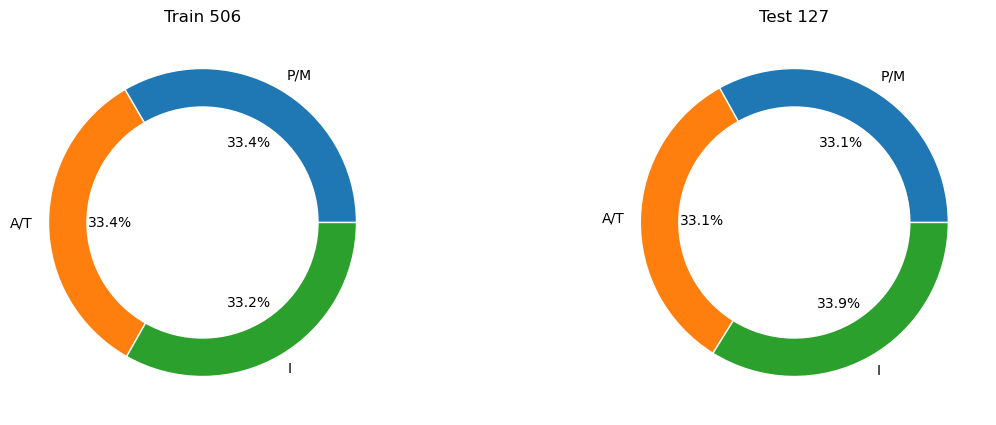

In [51]:
from sklearn.model_selection import train_test_split


img_dir = v.data_path + 'CellDivision/images/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

train = pd.read_csv(label_train_dir, header=None)
val = pd.read_csv(label_val_dir, header=None)
test = pd.read_csv(label_test_dir, header=None)

data = pd.concat([train, val, test], ignore_index=True)

plt.figure(figsize=(14, 5))

train, test = train_test_split(data, test_size=0.2, stratify=data[1])

for i, dataset in enumerate([train, test]):
    plt.subplot(1, 2, i+1)
    plt.pie(
        np.bincount(dataset[1].astype(int)), 
        labels=['P/M', 'A/T', 'I'],
        colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
        autopct='%.1f%%',
        wedgeprops=dict(width=.25, edgecolor='w')
    )

    plt.title([f'Train {len(train)}', f'Test {len(test)}'][i])
    
plt.show()

In [46]:
from sklearn.model_selection import RepeatedStratifiedKFold


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)

train_scores = []
val_scores = []
test_scores = []

In [ ]:
bar = LoadingBar(cv.get_n_splits(train))

test.to_csv(label_test_dir, index=False, header=False)
test_generator = CellDataset(
    img_dir, label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

best_model = None
for train_idx, val_idx in cv.split(train[0], train[1]):
    # Data partitioning
    train.iloc[train_idx].to_csv(label_train_dir, index=False, header=False)
    train.iloc[val_idx].to_csv(label_val_dir, index=False, header=False)
    
    train_generator = CellDataset(
        img_dir, label_train_dir,
        batch_size=BATCH_SIZE,
        resize=INPUT_SHAPE[:2]
    )
    
    val_generator = CellDataset(
        img_dir, label_val_dir,
        batch_size=BATCH_SIZE,
        resize=INPUT_SHAPE[:2]
    )
    
    # Model creation
    model = CNN(
        base=tf.keras.applications.VGG16,
        input_shape=INPUT_SHAPE,
        n_classes=3,
        fine_tune=True
    )
    model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
    model.compile(
        lr=.001,
        loss=extended_w_cel_loss()
    )
    model.fit(
        train_generator,
        val_generator,
        epochs=100,
        verbose=0,
        save=False,
        batch_size=BATCH_SIZE
    )
    
    train_scores.append(model.model.evaluate(train_generator, verbose=0)[1])
    val_scores.append(model.model.evaluate(val_generator, verbose=0)[1])
    test_scores.append(model.model.evaluate(test_generator, verbose=0)[1])
    
    if best_model is None or val_scores[-1] > max(val_scores[:-1]):
        best_model = model
    
    clear_session()
    bar.update()
    
bar.end()

best_model.model.save('../models/cellular_division_models/vgg16_hyper_under.h5')